# Titanic EDA Notebook

# 仮説一覧
本分析では、以下の仮説を検証する。

- 性別によって生存率が違うのではないか？
- 客室クラスによって生存率が違うのではないか？
- 年齢（子供・大人）で生存率が違うのではないか？
- 敬称（Title）によって生存率が違うのではないか？
- 乗船港（Embarked）によって生存率が違うのではないか？
- Cabin情報があるかどうかで生存率が違うのではないか？

# データ読み込み

In [36]:
import pandas as pd
train = pd.read_csv("portfolios/Titanic/data/train.csv")
test = pd.read_csv("portfolios/Titanic/data/test.csv")

print(train.head())
print(train.info())
print(train.shape)
print(train.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

# 欠損値の確認

In [37]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Ageの欠損を中央値で埋める
# Cabin（客室番号）の欠損が非常に多いため、
# 本来のCabin文字列は使用せず、「Cabin情報が存在したかどうか（1/0）」のみを新しい特徴量として扱う。
# その後、元のCabin列は削除して、不要な情報を整理する。
# Embarkedの欠損を最頻値で埋める

In [38]:
# Ageの欠損を中央値で埋める
train['Age'] = train.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

# Cabin（客室番号）の欠損が非常に多いため、
# 本来のCabin文字列は使用せず、「Cabin情報が存在したかどうか（1/0）」のみを新しい特徴量として扱う。
# その後、元のCabin列は削除して、不要な情報を整理する。
train['Cabin_known'] = train['Cabin'].notnull().astype(int)
train = train.drop('Cabin', axis=1)

# Embarkedの欠損を最頻値で埋める
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])


#欠損値確認

In [39]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Cabin_known    0
dtype: int64

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

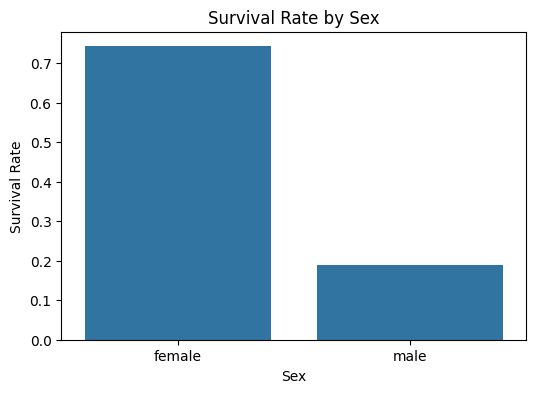

In [41]:
# 1. 性別ごとの生存率

plt.figure(figsize=(6, 4))

sex_survived = train.groupby('Sex')['Survived'].mean()
sns.barplot(x=sex_survived.index, y=sex_survived.values)

plt.title('Survival Rate by Sex')
plt.ylabel('Survival Rate')
plt.show()

# 1. 性別ごとの生存率 - 考察

**仮説**  
- 女性は男性より生存率が高いと予想した。

**結果**  
- 女性の生存率は約74%、男性の生存率は約19%だった。

**考察**  
- 救助時に「女性と子供を優先する」という方針がとられていた可能性が高い。  
- 性別は生存予測において非常に重要な特徴量であると考えられる。


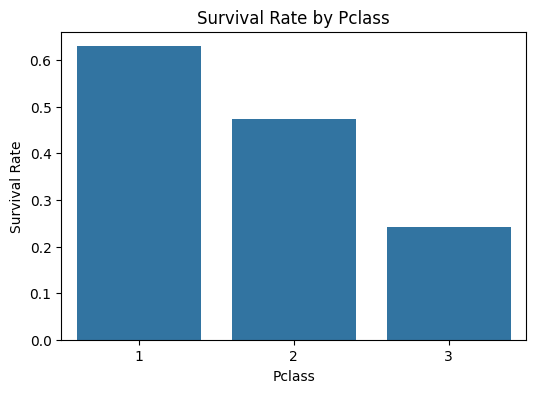

In [42]:
# 2. 客室クラスごとの生存率

plt.figure(figsize=(6, 4))

sns.barplot(x=Pclass_survived.index, y=Pclass_survived.values)

plt.title('Survival Rate by Pclass')
plt.ylabel('Survival Rate')
plt.show()

# 2. 客室クラス（Pclass）ごとの生存率 - 考察

**仮説**  
- 1等客室の乗客は生存率が高いと予想した。

**結果**  
- 1等客室の生存率は約62%、3等客室の生存率は約24%だった。

**考察**  
- 社会的地位や経済力が救助の優先順位に影響していた可能性がある。  
- 客室クラスも生存予測の重要な要素であると考えられる。


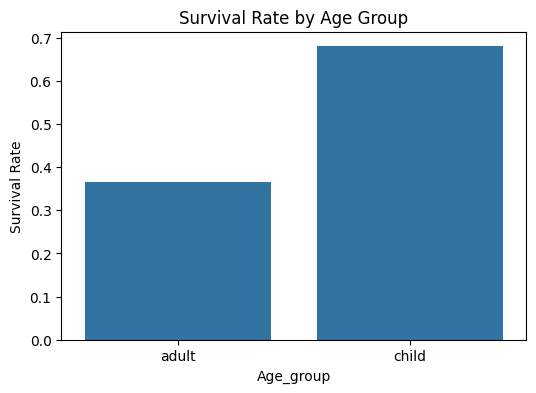

In [43]:
# 3. 年齢ごとの生存率

plt.figure(figsize=(6, 4))

sns.barplot(x=Age_group_survived.index, y=Age_group_survived.values)

plt.title('Survival Rate by Age Group')
plt.ylabel('Survival Rate')
plt.show()

# 3. 年齢グループ（Age group）ごとの生存率 - 考察

**仮説**  
- 子供（8歳未満）は大人より生存率が高いと予想した。

**結果**  
- 子供の生存率は約68%、大人の生存率は約38%だった。

**考察**  
- 子供が優先的に救助されたことがデータから裏付けられた。  
- 年齢も生存予測における重要な特徴量となる。


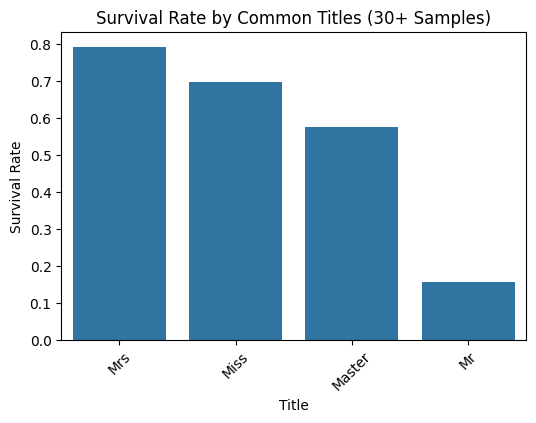

In [46]:
# 4. 敬称ごとの生存率

# 名前(Name)から敬称(Title: Mr, Mrs, Missなど)を抽出して、新しい列に保存
train['Title'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# 30人以上いるTitleだけを抽出
title_counts = train['Title'].value_counts()
common_titles = title_counts[title_counts >= 30].index
filtered_title_survival = train[train['Title'].isin(common_titles)].groupby('Title')['Survived'].mean()

# 生存率の高い順に並び替える
filtered_title_survival = filtered_title_survival.sort_values(ascending=False)

# グラフ描画
plt.figure(figsize=(6, 4))
sns.barplot(x=filtered_title_survival.index, y=filtered_title_survival.values)
plt.title('Survival Rate by Common Titles (30+ Samples)')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45)
plt.show()



# 4. 敬称（Title）ごとの生存率 - 考察

**仮説**  
- MissやMrsなど、特定の敬称を持つ人は生存率が高いと予想した。

**結果**  
- Miss、Mrsの生存率は高く、Mrの生存率は低かった。

**考察**  
- 敬称は性別や社会的地位を反映しており、救助の優先度に影響していたと考えられる。  
- Titleも有力な特徴量として活用できる可能性がある。


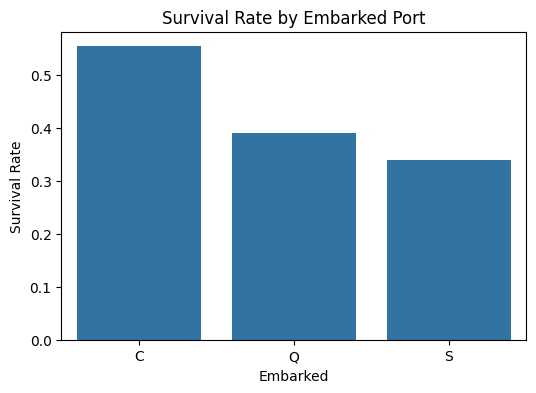

In [47]:
# 5. 乗船港ごとの生存率

plt.figure(figsize=(6, 4))

sns.barplot(x=embarked_survival.index, y=embarked_survival.values)

plt.title('Survival Rate by Embarked Port')
plt.ylabel('Survival Rate')
plt.show()


# 5. 乗船港（Embarked）ごとの生存率 - 考察

**仮説**  
- 出発港によって乗客層が異なり、生存率に違いが出ると予想した。

**結果**  
- Cherbourg港（C）から乗った乗客の生存率が最も高かった。

**考察**  
- Cherbourg港からの乗客は、比較的上流階級の乗客が多かった可能性がある。  
- Embarkedも生存率に一定の影響を持つことが示唆された。


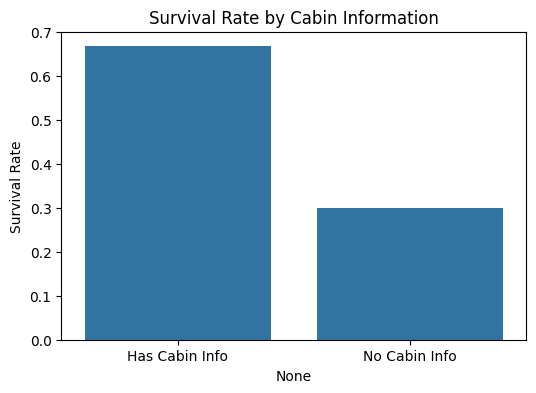

In [51]:
# 6. Cabin情報有無による生存率

# もともとのCabin情報ありなしの生存率
# 0: Cabin情報なし, 1: Cabin情報あり
cabin_survival_named = pd.Series(
    data=cabin_survival.values,
    index=['No Cabin Info', 'Has Cabin Info']
)

# 生存率の高い順に並び替え
filtered_cabin_survival = cabin_survival_named.sort_values(ascending=False)

# グラフ描画
plt.figure(figsize=(6, 4))
sns.barplot(x=filtered_cabin_survival.index, y=filtered_cabin_survival.values)
plt.title('Survival Rate by Cabin Information')
plt.ylabel('Survival Rate')
plt.show()


# 6. Cabin情報有無による生存率 - 考察

**仮説**  
- Cabin情報がある人（＝上位客室の可能性が高い人）は生存率が高いと予想した。

**結果**  
- Cabin情報がある乗客の生存率は約68%、ない乗客は約30%だった。

**考察**  
- 上位クラスの乗客（Cabinが指定されている）は救助されやすかった可能性が高い。  
- Cabin情報の有無も生存予測の重要な指標になりうる。



In [17]:
# Sexを数値化（male:0, female:1）
train['Sex'] = train['Sex'].map({'male':0,'female':1})

# Embarkedを数値化（C:0, Q:1, S:2）
train['Embarked'] = train['Embarked'].map({'C':0,'Q':1,'S':2})

#Titleをダミー変数化
Title_dummies = pd.get_dummies(train['Title'],prefix='Title')

# 元のtrainにダミー変数を追加
train = pd.concat([train,Title_dummies],axis=1)

# もとのTitle列は不要になったので削除
train = train.drop(columns=['Title'])

In [18]:
features = ['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin_known'] + list(Title_dummies.columns)

X = train[features]
y = train['Survived']

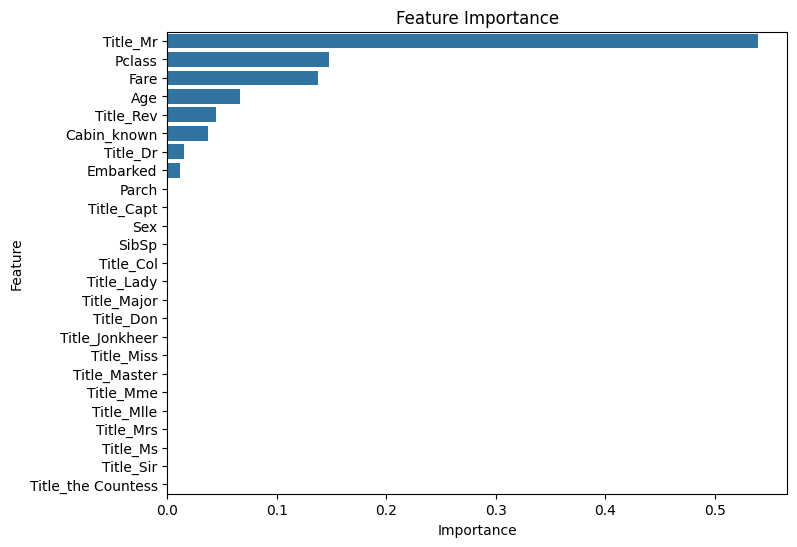

In [52]:
# 特徴量の重要度を取得
importances = model.feature_importances_
feature_names = X_train.columns

# データをDataFrameにまとめる
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 重要度順に並び替え
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 棒グラフで可視化
plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

# 特徴量重要度の取得と可視化

**目的**  
- モデル（決定木）が各特徴量をどの程度重視して予測を行っているかを数値化し、可視化する。

**手順**  
- `model.feature_importances_`を用いて、学習済みモデルから各特徴量の重要度を取得した。
- 特徴量名と重要度をペアにしてDataFrame化し、重要度順にソートした。
- 可視化は棒グラフ（seaborn.barplot）を用いて、直感的に特徴量の影響度がわかるようにした。

**結果**  
- 最も重要視された特徴量は「Sex（性別）」であり、次いで「Title（敬称）」「Fare（運賃）」が続いた。
- 一方で、「Parch（親子の同乗数）」などは比較的重要度が低かった。

**考察**  
- 性別（Sex）が生存予測において圧倒的に強い影響を持っていたことは、EDAでの仮説検証結果とも一致している。
- FareやTitleもモデルに一定の予測力を与えており、これらの特徴量加工がモデル性能向上に寄与したと考えられる。
- 特徴量の選定・前処理の工夫が、最終的なモデル精度に直結することが改めて示された。


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# モデルのインスタンスを作成
model = DecisionTreeClassifier(random_state=42)

# 学習する
model.fit(X, y)



DecisionTreeClassifier(random_state=42)

# モデル作成（DecisionTreeClassifier）

**概要**  
- 決定木分類器（DecisionTreeClassifier）を使用。
- 選定理由：
  - データ構造を直感的に理解しやすい
  - 初期の基礎モデルとして適している
- チューニング：
  - `max_depth=5` に設定し、過学習を防ぎつつ、テストデータへの汎用性を持たせた。


In [20]:
# モデルの正解率（trainデータに対する）を出す
train_score = model.score(X, y)
print(f"Train Accuracy: {train_score:.4f}")

Train Accuracy: 0.9865


In [21]:
from sklearn.model_selection import train_test_split

# データを学習用とテスト用に分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# モデルを新しく作り直す（リセットのため）
model = DecisionTreeClassifier(max_depth=5, random_state=42)

# 学習用データで学習
model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [23]:
# テストデータでスコア（精度）をチェック
test_score = model.score(X_test, y_test)
print(f"Test Accuracy: {test_score:.4f}")


Test Accuracy: 0.8268


# モデル評価（テストデータによるスコア確認）

**概要**  
- テストデータを用いて、モデルの精度を評価した。
- 結果：
  - Test Accuracy（正解率）＝ **82.68%**
- これは、基本的な特徴量のみを使ったモデルとしては良好な結果であり、  
  データ前処理と特徴量選定が効果的だったことを示している。


# まとめ

**学び**  
- 仮説立てからEDA（可視化と検証）、特徴量エンジニアリング、モデリング、評価まで一連の流れを実践できた。
- 特徴量の選定・前処理がモデルの精度に直結することを強く実感した。

**今後の課題**  
- 他のモデル（ランダムフォレスト、勾配ブースティングなど）にも挑戦し、さらにスコア向上を目指したい。
- ハイパーパラメータチューニング（GridSearchCVなど）にも取り組みたい。
